In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
import tensorflow as tf
import matplotlib 
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
from scipy import io
from scipy.spatial import Delaunay
import numpy as np
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import arctan2 as arctan2
import os
import statistics
import pickle
from stl import mesh
import time
import math
np.set_printoptions(threshold=np.inf, linewidth=200)

#本代码为DASA方法,属于Tensorflow深度学习加速后的IASA

#此章为初始参数及图像显示

#初始参数：
# f频率 c水中声速 lambda波长 
# N目标图像素点 P目标图像素点对应物理尺寸（m） z目标成像平面距离超声发射平面距离（m）
# dk水和相位板介质水中波数差
# T0相位板最大厚度，为打印所需最低厚度0.001m(0.1mm)加调制声场所需增加的厚度dk
def init_param():
    ### 当前为IASA方法还原，设定1mhz超声换能器，相位板为树脂材料，水中声速约1482m.s，商家预估材料声速2223.2m/s，最低板厚需
    f0 = 2e06
    c0 = 1482
    c1 = 2223.2#透明树脂
    l_ambda = c0/f0
    N = 80
    p = 0.0006
    z = 0.02
    dk=f0*(1/c0-1/c1)
    T0=0.001+1/dk#最大厚度，0.001留底+1/dk
    return N, z, p, l_ambda, T0, f0, c0
#numpy——强度图到灰度图转换    
def amp_abs(amp_cgh_img):
    new_amp_cgh = amp_cgh_img / amp_cgh_img.max() * 255
    return new_amp_cgh
#numpy——相位图-pi-pi转为灰度图0-255
def phaser_draw(phase_dist):
    new_phase_dist = phase_dist
    while new_phase_dist.min() < 0:
      new_phase_dist += math.pi*2
    new_phase_dist = (new_phase_dist % (2*math.pi))/(2*math.pi)
    new_phase_dist = new_phase_dist * 255
    return new_phase_dist
#打印图像
def show_imgs(imgs):
    for i in range(len(imgs)):
      img = imgs[i]
      plt.figure(figsize=(6,6))
      plt.imshow(img)
      plt.gray()
    plt.show()


In [4]:
#此章节为传播函数及其约束
#参考k-Wave http://www.k-wave.org/documentation/angularSpectrumCW.php
def band_limited_angular_h(k, N, l_ambda, z, p, f0, c0):
    N = N * 2
    if N%2==0:
        k_vec = np.arange(-N/2, N/2)
    else:
        k_vec = np.arange(-((N-1)/2), ((N-1)/2)+1)
    k_vec *= (2*math.pi) / (N*p)
    
    k_vec[int(N/2)] = 0
    
    k_vec = np.fft.ifftshift(k_vec)
    kx, ky = np.meshgrid(k_vec, k_vec)

    k = 2*math.pi*f0 / c0

    kz = pow(k**2 -  (pow(kx, 2) + pow(ky, 2))+0j, 0.5)
    sqrt_kx2_ky2 = pow(pow(kx,2) + pow(ky, 2), 0.5)

    H = np.conj(np.exp(1j * z * kz))
    D = (N- 1) * (p)
    kc = k * pow(0.5 * D**2 / (0.5 * D**2 + z**2) , 0.5)
    
    kh = np.where(sqrt_kx2_ky2 > kc, 0, H)
    return kh

def angular_spectrumCW(input_image, select_h):
  M = input_image.shape[0]
  init_plane_add = tf.pad(input_image, ((M//2,M//2), (M//2,M//2)), 'constant')
  N = init_plane_add.shape[0]
  fft_length = M #for case of 512 which is the case up here input size 256 x 256
  init_shift = tf.signal.fft2d(init_plane_add)
  prop = tf.signal.ifft2d(tf.math.multiply(init_shift, select_h))
  N = prop.shape[0]
  M = N // 2
  start_num = M//2
  end_num = N - M//2
  pressure = prop[start_num:end_num, start_num:end_num]
  return pressure

In [5]:
#此章节为厚度计算
def calculate_alpha(phase, f0):#计算alpha_t
    # Hologram材料
    c_h = 2223.2#透明树脂
    rho_h = 1170#透明树脂
    Z_h = c_h * rho_h
    k_h = (2*math.pi*f0) / c_h
    #transducer surface (assume gel to be impedance matched with hologram)
    Z_t = Z_h
    # water
    rho_m = 1000
    c_m = 1482
    Z_m = c_m * rho_m
    k_m = (2*math.pi*f0) / c_m
    phase = tf.math.angle(phase).numpy()
    delta_phase =phase % (2*math.pi)
    delta_T = delta_phase / (k_m-k_h)
    Thickness = T0 - delta_T
    alpha_t_top = (4*Z_t*(Z_h**2)*Z_m);
    alpha_t_bot_1 = (Z_h**2 * (Z_t + Z_m)**2) * pow(tf.math.cos((k_h * Thickness)), 2)
    alpha_t_bot_2 = (Z_h**2 + Z_t*Z_m)**2 * pow(tf.math.sin((k_h * Thickness)), 2)
    alpha_t = pow(alpha_t_top / (alpha_t_bot_1 + alpha_t_bot_2), 0.5)
    return alpha_t,Thickness#得到的是相位板反相厚度

def calculate_alpha2(phase, f0):#计算打印相位板的厚度
    # Hologram材料
    c_h = 2223.2#透明树脂
    k_h = (2*math.pi*f0) / c_h
    # water
    c_m = 1482
    k_m = (2*math.pi*f0) / c_m
    #phase = tf.math.angle(phase).numpy()
    delta_phase = 2*math.pi- phase % (2*math.pi)#phase变负
    delta_T = delta_phase / (k_m-k_h)
    Thickness = T0 - delta_T
    return Thickness


In [6]:
#此章节为结果讨论

#损失函数：CSIM,SSIM,uniformity,psnr，efficiency，accuracy，PC，loss_func()SSE/MSE
def CSIM(true, pred):#cos_sim: 标量张量，值域[-1, 1]（若元素非负则多在[0,1]）
    # 展平到一维向量
    true_flat = tf.reshape(true, [-1])
    pred_flat = tf.reshape(pred, [-1])
    
    dot_val   = tf.reduce_sum(true_flat * pred_flat)
    norm_true = tf.norm(true_flat)
    norm_pred = tf.norm(pred_flat)
    
    cos_sim = dot_val / (norm_true * norm_pred + 1e-12)  # 加1e-12防止分母为0
    return cos_sim

def SSIM(true, pred, max_val=1.0):#ssim_val: 标量张量，通常在[0,1]区间
    # tf.image.ssim 要求输入为 4D: [batch, height, width, channels]
    true_4d = tf.reshape(true, [1, tf.shape(true)[0], tf.shape(true)[1], 1])
    pred_4d = tf.reshape(pred, [1, tf.shape(pred)[0], tf.shape(pred)[1], 1])
    
    ssim_per_batch = tf.image.ssim(true_4d, pred_4d, max_val=max_val)
    # tf.image.ssim 返回 [batch]，这里只有 batch=1，直接取第0项或用 reduce_mean
    return tf.reduce_mean(ssim_per_batch)

def uniformity(true,pred):
    on_target = tf.math.multiply(true, pred)
    zero_mask = tf.math.not_equal(on_target, 0)
    on_target_mean = tf.reduce_mean(tf.boolean_mask(on_target, zero_mask))
    on_target_std = tf.math.reduce_std(tf.boolean_mask(on_target,zero_mask))
    return 1-on_target_std/on_target_mean

# Calculation of PSNR ratio in dB
def psnr(true, pred):
    M = true.shape[0]
    differ = np.sum(pow((true.numpy() - pred), 2)) / (M*M)
    PSNR = 20*np.log10(255 / np.sqrt(differ))
    return PSNR

def efficiency(true, pred):
    # Calculation for on-target efficiency
    zero_mask = tf.math.not_equal(true, 0)
    # Adding a small value to avoid division by zero
    on_target_mean = tf.reduce_mean(tf.boolean_mask(pred, zero_mask)) 
        
    # Calculation for off-target efficiency
    non_zero_mask = tf.math.equal(true, 0)
    off_target_mean = tf.reduce_mean(tf.boolean_mask(pred, non_zero_mask))   
    return on_target_mean, off_target_mean

def PC(true, pred):#Pearson Correlation (皮尔逊相关系数)pearson_r: 标量张量, 取值[-1,1]
    true_flat = tf.reshape(true, [-1])
    pred_flat = tf.reshape(pred, [-1])

    mean_t = tf.reduce_mean(true_flat)
    mean_p = tf.reduce_mean(pred_flat)
    diff_t = true_flat - mean_t
    diff_p = pred_flat - mean_p

    numerator = tf.reduce_sum(diff_t * diff_p)
    denominator = tf.sqrt(tf.reduce_sum(diff_t**2) * tf.reduce_sum(diff_p**2)) + 1e-12
    pearson_r = numerator / denominator
    return pearson_r

def SSE(true,pred):#SSE，目标强度与当前强度之间的二范数距离（或者说强度差的平方和）直接累加

    loss = tf.reduce_sum(tf.square(true - pred))
    return loss

def MSE(true,pred):#SSE，目标强度与当前强度之间的二范数距离（或者说强度差的平方和）累加除以元素总数就是MSE
    loss = tf.reduce_mean(tf.square(true - pred)) 
    return loss

def MAE(true,pred):
    loss = tf.reduce_mean(tf.abs(true - pred))  # 平均绝对误差 MAE
    return loss
##用于深度学习正负样本检测
# def accuracy(true, pred): # cosine similarity based loss function
#     denom = tf.sqrt(tf.reduce_sum(tf.pow(pred, 2), axis=[1, 2]) *tf.reduce_sum(tf.pow(true, 2), axis=[1, 2]))
#     return 1 - tf.reduce_mean((tf.reduce_sum(pred * true, axis=[1, 2]) + 0.001) / (denom + 0.001),axis=0)


In [13]:
### Get initialization values
N, z, p, l_ambda, T0, f0, c0 = init_param()
k = 2*np.pi/l_ambda
target_amp = 1

#传播函数
forward_h = band_limited_angular_h(k, N, l_ambda, z, p, f0, c0)
#back_h = tf.math.conj(forward_h)

##### Target Amplitude #####
in_dir ='/root/autodl-tmp/0324trans/Input/'
size = (N, N)
amp_img_np =np.zeros((80,80),dtype=np.uint8)

# # #4个点
# amp_img_np[20,20]=255
# amp_img_np[60,60]=255
# amp_img_np[60,20]=255
# amp_img_np[20,60]=255
# #8个点
# amp_img_np[20,20]=255
# amp_img_np[60,60]=255
# amp_img_np[60,20]=255
# amp_img_np[20,60]=255
# amp_img_np[52,28]=255
# amp_img_np[28,52]=255
# amp_img_np[52,52]=255
# amp_img_np[28,28]=255

# #  2025
mat = np.zeros(( 80, 80), dtype=np.uint8)
block_size = 8
offset = 12  # 12，相当于块中心相对于块起点的偏移
data2025=[[1,0,0,0,1,0,1,0],#2
          [0,1,1,0,1,1,0,1],#3
          [0,1,1,1,0,0,1,0],#4
          [0,0,1,0,0,0,0,1],#5
          [0,0,0,0,0,1,1,1],#6
          [1,1,0,1,0,0,1,1],#7
          [1,0,1,0,1,0,0,1],#8
          [0,1,0,0,0,1,0,1]]#9
for i in range(8):
    for j in range(8):
        data2025[i][j] *= 255
print(data2025)
for i2 in range(8):
    for j2 in range(8):
        row = i2 * block_size + offset
        col = j2 * block_size + offset
        mat[row][col] = data2025[i2][j2]
amp_img_np = cv2.resize(mat, size)  

# # 8*8
# mat = np.zeros(( 80, 80), dtype=np.uint8)
# block_size = 8
# offset = 12  # 12，相当于块中心相对于块起点的偏移
# for i2 in range(8):
#     for j2 in range(8):
#         row = i2 * block_size + offset
#         col = j2 * block_size + offset
#         #mat[row][col] = data2025[i2][j2]
#         mat[row][col] = 255
# amp_img_np = cv2.resize(mat, size)  

#目标图,80*80像素png格式
# amp_img_np = cv2.imread(in_dir+ 'target.png', cv2.IMREAD_GRAYSCALE)
#图像不标准就改改尺寸
# amp_img_np = cv2.resize(amp_img_np, size)



#target 强度分布,损失计算中的 pred
target_img = tf.dtypes.cast(amp_img_np/ 255.0 * target_amp, tf.complex128)

##### Input #####
input_int = cv2.imread(in_dir + 'test_transducer.png', cv2.IMREAD_GRAYSCALE)
size = (N, N)
input_int = cv2.resize(input_int, size)#统一尺寸为（N，N）
input_int = tf.dtypes.cast(input_int / 255.0, tf.float64)

##### SLM照明光分布 #####
light_img = tf.dtypes.cast(input_int, tf.complex128)

##### 初始化 phase #####
in_plane_phase = np.zeros(size)


[[255, 0, 0, 0, 255, 0, 255, 0], [0, 255, 255, 0, 255, 255, 0, 255], [0, 255, 255, 255, 0, 0, 255, 0], [0, 0, 255, 0, 0, 0, 0, 255], [0, 0, 0, 0, 0, 255, 255, 255], [255, 255, 0, 255, 0, 0, 255, 255], [255, 0, 255, 0, 255, 0, 0, 255], [0, 255, 0, 0, 0, 255, 0, 255]]


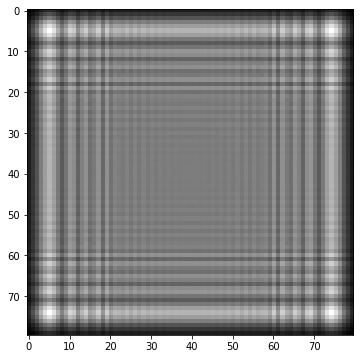

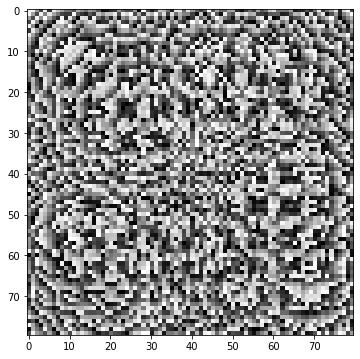

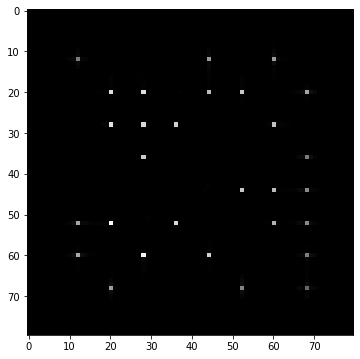

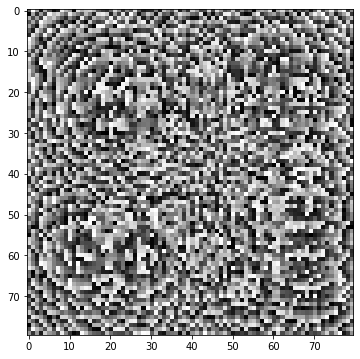

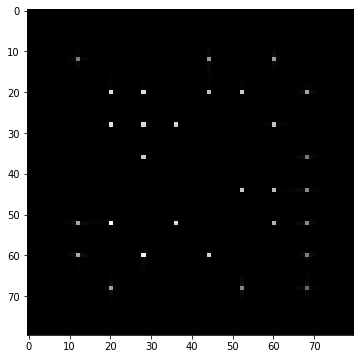

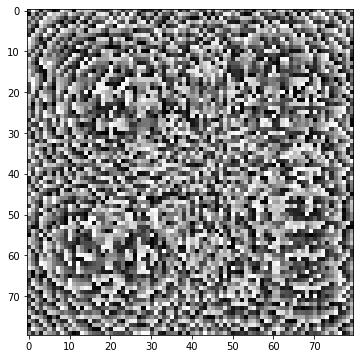

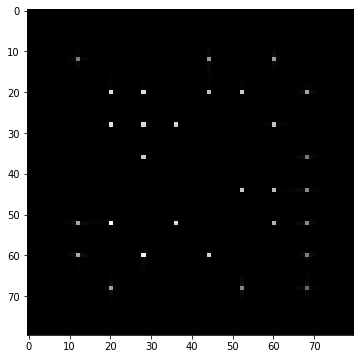

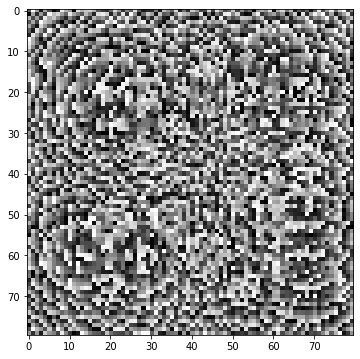

Height matrix min: 1.000453831947484
Height matrix max: 3.2221437383818854


In [14]:
Computationtime_log=[]
#梯度损失
ls_log=[]
#目标图像
target = tf.dtypes.cast(target_img*tf.math.conj(target_img), tf.float64)

for i in range(2000):
  start_t = time.time()  
  #计算当前传播结果intensity,与target传播结果比较
  input_plane = light_img*np.exp(1j*in_plane_phase)
  pressure = angular_spectrumCW(input_plane, forward_h)
  intensity = tf.dtypes.cast(pressure*tf.math.conj(pressure), tf.float64)
   
  retain_phase = tf.math.angle(pressure).numpy()
  at_target = target_img*np.exp(1j*retain_phase)
  #back_pressure = tf.math.conj(angular_spectrumCW(tf.math.conj(at_target), forward_h))#若没有alpha调节就直接反向传播
  alpha=calculate_alpha(at_target, f0)[0]
  alpha=tf.dtypes.cast(alpha, tf.complex128)
  alpha_at_target = alpha*target_img*np.exp(1j*retain_phase)
  
  back_pressure = tf.math.conj(angular_spectrumCW(tf.math.conj(alpha_at_target), forward_h))
  phaseK = tf.math.angle(back_pressure)
  in_plane_phase = phaseK.numpy()
  in_plane_phase = np.where(input_int  == 0, 0, in_plane_phase)
  phase = tf.Variable(in_plane_phase)

  end_t = time.time()
  # Evaluate performance  
  intensity_np = intensity.numpy()
  ls_log.append(tf.reduce_mean(pow((intensity - target),2)))
  elapsed_sec = end_t - start_t
  Computationtime_log.append(elapsed_sec)
 
  if (i%500) ==0:
      imgs = [
        amp_abs(intensity.numpy()),
        phaser_draw(phase.numpy())
      ]
      show_imgs(imgs)

# Exporting results
exporting_phase = phaser_draw(phase.numpy())
exporting_intensity = amp_abs(intensity.numpy())
T=calculate_alpha2(in_plane_phase, f0)
height_matrix = T * 1000.00
#确认厚度范围，根据打印厂家参数设计
print("Height matrix min:", height_matrix.min())
print("Height matrix max:", height_matrix.max())

#pad_size = 1  # 填充的边界大小
pad_size = (100 - 80) // 2  # 填充的边界大小
height_precision=0.1
height_matrix =(np.round(height_matrix / height_precision)) * height_precision
# 使用 np.pad 进行填充
height_matrix = np.pad(
        height_matrix,
        pad_width=((pad_size, pad_size), (pad_size, pad_size)),  # 上下和左右填充
        mode='constant',
        constant_values=1.0)#填充厚度为1mm
#print(height_matrix)
#print(np.shape(height_matrix))


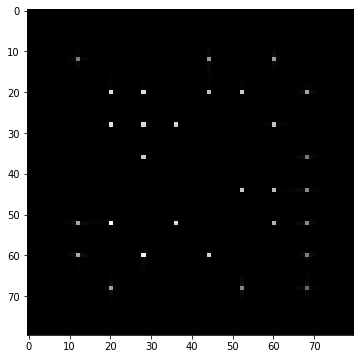

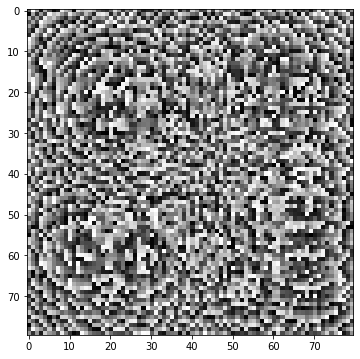

over


In [15]:
#保存仿真分析和仿真结果 
#保存随迭代次数CSIM	SSIM	uniformity	psnr	Efficiency	Computationtime[sec]	PC	MSE	SSE的变化，每次运行完保存到一个文件内统计损失函数的稳定性
#CSIM
imgs = [
        amp_abs(intensity_np),
        phaser_draw(phase.numpy())
      ]
show_imgs(imgs)
exporting_intensity = amp_abs(intensity.numpy())
loadfile='0.6mm_' + '2025points_'+'2000ite_' + 'KaiMelde_'+'2m_'
#firsttarget 2cm
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/csvintensity/'+loadfile+'1.csv', np.array(intensity), delimiter=',')
io.savemat('/root/autodl-tmp/0324trans/loss0.6mm/intensitymat/'+loadfile+'1.mat', {'recon':intensity_np})

#保存每次生成的最终的相位板声场图和聚焦强度图
cv2.imwrite('/root/autodl-tmp/0324trans/intensity/'+loadfile+'1.png', exporting_intensity)

#保存每次生成的最终的结果图像true
cv2.imwrite('/root/autodl-tmp/0324trans/phase/'+loadfile+'1.png', exporting_phase)

#综合损失
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/ls/'+loadfile+'1.csv', np.array(ls_log), delimiter=',')

#双平面迭代时间
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/Computationtime/'+loadfile+'1.csv', np.array(Computationtime_log), delimiter=',')

#保存最终的厚度图T的保存到二进制文件numpy版本和mat版本
np.save('/root/autodl-tmp/0324trans/T0.6mm/numpy/'+loadfile+'1.npy', height_matrix)
io.savemat('/root/autodl-tmp/0324trans/T0.6mm/mat/'+loadfile+'1.mat', {'height_matrix': np.array(height_matrix)})
print('over')

程序运行时长: 67.97510552406311 秒


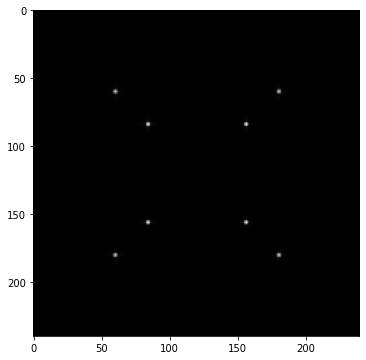

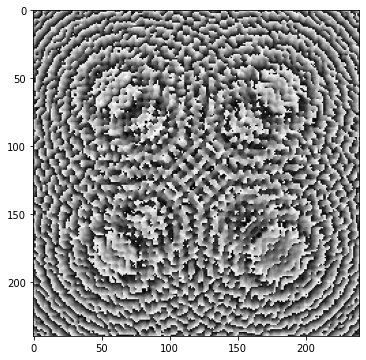

True

In [47]:
target_amp = 1
amp_img_np1 =np.zeros((80,80),dtype=np.uint8)
#4个点
# amp_img_np1[20,20]=255
# amp_img_np1[60,60]=255
# amp_img_np1[60,20]=255
# amp_img_np1[20,60]=255
#8个点
amp_img_np1[20,20]=255
amp_img_np1[60,60]=255
amp_img_np1[60,20]=255
amp_img_np1[20,60]=255
amp_img_np1[52,28]=255
amp_img_np1[28,52]=255
amp_img_np1[52,52]=255
amp_img_np1[28,28]=255

target_img1 = tf.dtypes.cast(amp_img_np1/ 255.0 * target_amp, tf.complex128)

in_plane_phase = phase.numpy()
in_plane_phase = np.where(input_int  == 0, 0, in_plane_phase)
phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))
##### Input #####
input_int = phase_exp
##### Transducer Inputs #####
light_img = tf.dtypes.cast(input_int, tf.complex128)
##### Randomize phase #####
in_plane_phase = np.zeros(size)
phase = tf.Variable(in_plane_phase)

SSM_log1 = []
MSE_log1 = []
CSIM_log1 = []
SSIM_log1 = []
uniformity_log1 = []
psnr_log1 = []
efficiency_log1 = []
PC_log1 = []
Computationtime_log1=[]

#综合损失
ls_log1=[]

##### Get Angular Spectrum #####
forward_h1= band_limited_angular_h(k, N, l_ambda, z, p, f0, c0)

# Get optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
step_count = 0;
#第二个相位板目标图像
target1 = tf.dtypes.cast(target_img1*tf.math.conj(target_img1), tf.float64)

for i in range(2000):
  start_t = time.time()  
  #计算当前传播结果intensity,与target传播结果比较
  input_plane = light_img*np.exp(1j*in_plane_phase)
  pressure1 = angular_spectrumCW(input_plane, forward_h1)
  intensity1 = tf.dtypes.cast(pressure1*tf.math.conj(pressure1), tf.float64)

  SSM_log1.append(SSM(intensity1,target1))
  MSE_log1.append(MSE(intensity1,target1))
  CSIM_log1.append(CSIM(intensity1,target1))
  SSIM_log1.append(SSIM(intensity1,target1))
  uniformity_log1.append(uniformity(intensity1,target1))
  psnr_log1.append(psnr(intensity1,target1))
  efficiency_log1.append(efficiency(intensity1,target1))
  PC_log1.append(PC(intensity1,target1))
    
  retain_phase1 = tf.math.angle(pressure1).numpy()
  at_target1 = target_img1*np.exp(1j*retain_phase1)
  alpha1=calculate_alpha(at_target1, f0)[0]
  alpha1=tf.dtypes.cast(alpha1, tf.complex128)
  alpha_at_target1 = alpha1*target_img1*np.exp(1j*retain_phase1)
   
  back_pressure = tf.math.conj(angular_spectrumCW(tf.math.conj(alpha_at_target1), forward_h1))
  phaseK = tf.math.angle(back_pressure)
  in_plane_phase = phaseK.numpy()
  in_plane_phase = np.where(input_int  == 0, 0, in_plane_phase)
  phase = tf.Variable(in_plane_phase)
  # Optimize Function
  step_count = opt.minimize(loss_func, [phase]).numpy()

  ls = loss_func()
  ls_log1.append(ls)
  end_t = time.time()
  elapsed_sec = end_t - start_t
  Computationtime_log.append(elapsed_sec)
  if (i%500) ==0:
      imgs = [
        amp_abs(intensity1.numpy()),
        phaser_draw(phase.numpy())
      ]
      show_imgs(imgs)

# Exporting results
exporting_phase = phaser_draw(phase.numpy())
exporting_intensity1 = phaser_draw(intensity1.numpy())

T=calculate_alpha2(in_plane_phase, f0)
height_matrix = T * 1000.00
#确认厚度范围，根据打印厂家参数设计
print("Height matrix min:", height_matrix.min())
print("Height matrix max:", height_matrix.max())

#pad_size = 1  # 填充的边界大小
pad_size = (100 - 80) // 2  # 填充的边界大小
height_precision=0.1
height_matrix =(np.round(height_matrix / height_precision)) * height_precision
# 使用 np.pad 进行填充
height_matrix = np.pad(
        height_matrix,
        pad_width=((pad_size, pad_size), (pad_size, pad_size)),  # 上下和左右填充
        mode='constant',
        constant_values=1.0)#填充厚度为1mm
#print(height_matrix)
#print(np.shape(height_matrix))

In [ ]:
#保存仿真分析和仿真结果 
#保存随迭代次数CSIM	SSIM	uniformity	psnr	Efficiency	Computationtime[sec]	PC	MSE	SSE的变化，每次运行完保存到一个文件内统计损失函数的稳定性
#CSIM
loadfile1='0.6mm_' + '2phasesecondtarget0404points_'+'2000ite_' + 'DASA_'+'2m_'
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/CSIM/'+loadfile1+'1.csv', np.array(CSIM_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/SSIM/'+loadfile1+'1.csv', np.array(SSIM_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/uniformity/'+loadfile1+'1.csv', np.array(uniformity_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/psnr/'+loadfile1+'1.csv', np.array(psnr_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/efficiency/'+loadfile1+'1.csv', np.array(efficiency_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/PC/'+loadfile1+'1.csv', np.array(PC_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/MSE/'+loadfile1+'1.csv', np.array(MSE_log1), delimiter=',')
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/SSM/'+loadfile1+'1.csv', np.array(SSM_log1), delimiter=',')
#保存每次生成的最终的结果图像true
cv2.imwrite('/root/autodl-tmp/0324trans/intensity1/'+loadfile1+'1.png', exporting_intensity1)
#保存每次生成的最终的结果图像true
cv2.imwrite('/root/autodl-tmp/0324trans/phase/'+loadfile1+'1.png', exporting_phase)
#综合损失
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/ls/'+loadfile1+'1.csv', np.array(ls_log1), delimiter=',')

#双平面迭代时间
np.savetxt('/root/autodl-tmp/0324trans/loss0.6mm/Computationtime/'+loadfile1+'1.csv', np.array(Computationtime_log1), delimiter=',')

#保存最终的厚度图T的保存到二进制文件numpy版本和mat版本
np.save('/root/autodl-tmp/0324trans/T0.6mm/numpy/'+loadfile1+'1.npy', height_matrix)
io.savemat('/root/autodl-tmp/0324trans/T0.6mm/mat/'+loadfile1+'1.mat', {'height_matrix': np.array(height_matrix)})